# Time Series Modelling

## Some questions

### What is time series modelling?

Time series modelling usually refers to the process of constructing statistical models that explain a time series in terms of its own past values - and sometimes even the past values of other time series. Such models are particularly appropriate for making forecasts.

### What's the difference between this and econometric modelling?

Econometric models are typically regression models that explain the current value of a time series in terms of the current value of other variables (although sometimes lagged explanatory variables are introduced.) Although such models are appropriate for understanding the drivers of a particular time series (for example the drivers of sales) they run into a problem when it comes to forecasting, since to forecast the response variable we need to forecast each of the explanatory variables. This can of course be done but since there is uncertainty around each forecast this creates even more uncertainty in the estimate of the response variable. We might as well just forecast the response variable using the methods we would use to forecast the explanatory variable.

### How is it done?

There are several methods to creating time series models. We will start by looking at the traditional ARIMA models. These are very powerful and flexible models that have the advantage of being built upon a fully worked out statistical theory. In the second session we will start to look at ways in which these models have been adapted to cope with a wider variety of real world scenarios.

We will be doing this in python using the statsmodels library


## Hands on
As usual, to build up our understanding of the situation we are going to start with the simplest of scenarios and gradually introduce complexity. More complex scenarios will require more complex models and we'll also start adding these in.

### Scenario 1: White noise

We are going to start with the simplest possible scenario that involves uncertainty: a white noise process. 

#### Where you might see this process?

Such processes are quite common in industry where attributes of items, produced over time (say the weight of cereal boxes measured on a production line) are normally distributed around an unchanging mean.


#### The generative model

The model for this process is

$Y_t = \mu + \epsilon_t$

Where

$\epsilon_t \sim N(0, \sigma^2)$


Note the process is **stationary**. This means its distributional properties (for example the mean value, the amount of variance and the amount of correlation with its own lagged values) do not change over time. This concept is very important. All our work will be on stationary processes and when processes aren't stationary we will transform them into stationary processes so we can work on them


### An example

First we need to set up our python libraries.

In [2]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.style.use('ggplot')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
num_time_periods = 2*365

As usual we are going to work with our own simulated data. Producing the data helps us understand the model. In the following code we generate a white noise process.

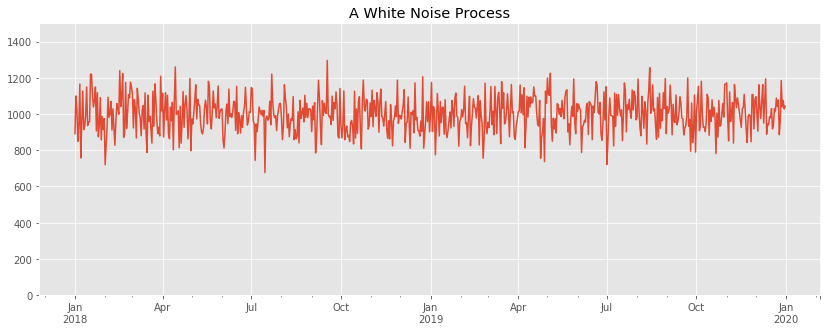

In [3]:
np.random.seed(123)
date_index = pd.date_range('2018-01-01', periods=num_time_periods, freq='D')
ts_values = np.random.normal(1000, 100, num_time_periods)
ts = pd.Series(ts_values, index=date_index)
fig, ax = plt.subplots(figsize=(14,5))
ax = ts.plot(title="A White Noise Process")
_ = ax.set_ylim(0, 1500)

#### How would you identify a white noise process?

Of course if we hadn't simulated the data we wouldn't know that it is a white noise process, so how would we check? 

On all of our time series we will use what is known as the *Box-Jenkins* approach to model identification.

First we need to establish that the process is stationary. It hardly needs doing but a plot of the residuals makes it fairly clear that neither the mean nor the variance of the process changes over time.

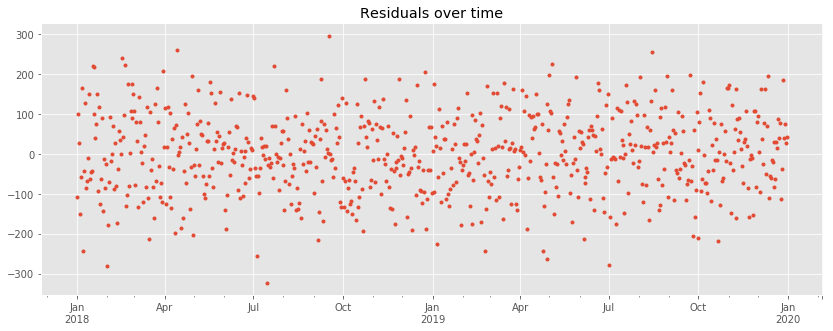

In [4]:
ts_res = ts - ts.mean(axis=0)
fig, ax = plt.subplots(figsize=(14,5))
ax = ts_res.plot(title="Residuals over time", style='.')

The next thing we might look at is the amount of correlations $Y_t$ has with lagged version of itself ($Y_{t-1}, Y_{t-2}$). A white noise process should not display any correlations since the error terms are independent.

The auto correlation plot below shows that they do not since the only significant correlation is with a lag of zero.

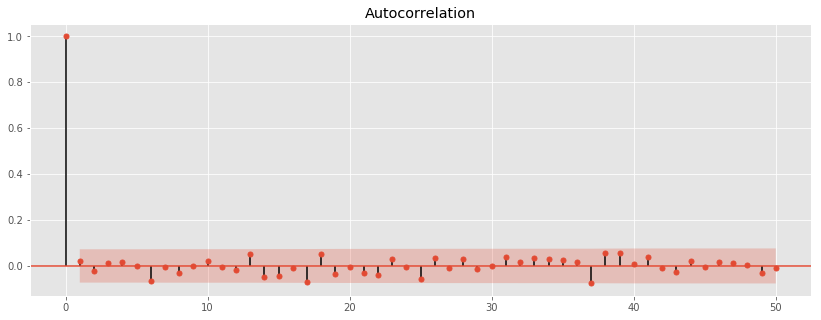

In [5]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,5))
    plot_acf(ts_values, lags = 50)

We should also introduce the partial autocorrelation function as it will become important later. PAC controls for correlations at shorter lags than the one being calculated. For example partial autocorrelation at lag 3 controls for correlations at lag 3 that might only be due to correlations at lag 2 or lag one.

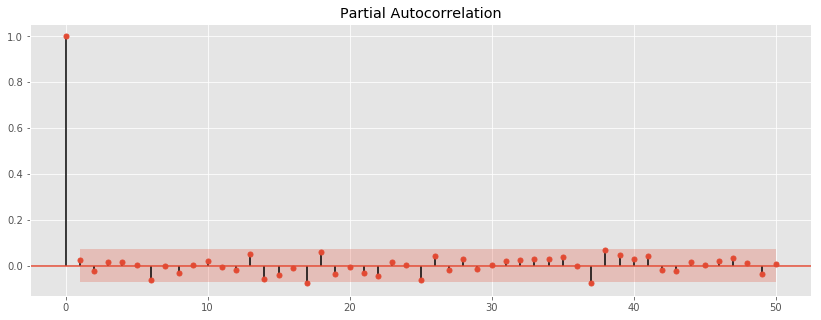

In [6]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,5))
    plot_pacf(ts_values, lags = 50)

There is also a more formal test we can do to investigate the hypothesis that the data has been generated by a white noise process.  The null hypothesis of the Ljung–Box test is that all the autocorrelations up to lag k equal zero. We can do this in python as follows:

In [7]:
p_values = acorr_ljungbox(ts_res, 10)[1]
print(p_values)

[0.53350791 0.69795467 0.83058758 0.90240277 0.95840218 0.67253719
 0.7754747  0.79377804 0.8630295  0.89491504]


None of the returned p-values for the 10 lags are significant indicating once again that this is a white noise process.

#### How do we forecast a white noise process?

Nothing could be simpler! The forecast is simply the mean of all previous values! Do not be fooled into thinking that the best forecasts are always sophisticated looking wiggles. Sometimes the best forecast is a straight line.

### Scenario 2: AR(1)

Now things get more interesting. Our next process, the AR(1) (autoregressive) process assumes that there is a correlation (positive or negative) between the current value of the time series and the previous value.

#### Where you might see this process?

A good example of this process is the number of active users on a platform where the current number of active users is made up of a certain proportion of the number of the previous week (a carry over) plus some additional noise caused by the net effect of acquisitions (or better than average retention) and worse than average retention.


#### The generative model

The model for this process is

$Y_t = \mu + \theta Y_{t-1} + \epsilon_t$

Where

$\epsilon_t \sim N(0, \sigma^2)$ 

and $-1 < \theta < -1 $ (A necessary condition if the process is to be stationary).


### An example

Simulating this data is a bit more interesting!

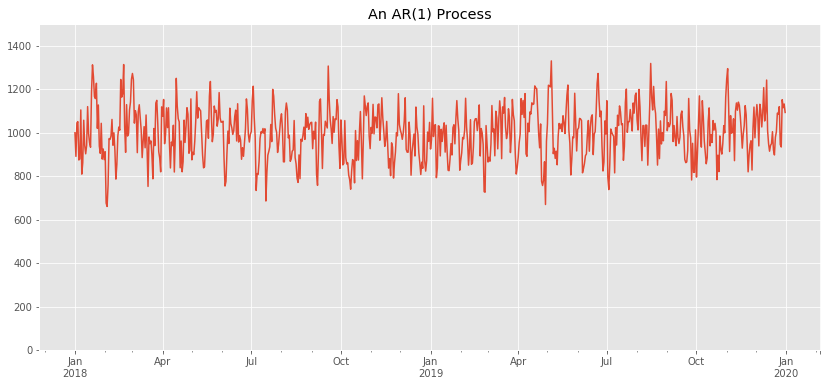

In [8]:
np.random.seed(123)
ts_values = [1000]
theta = 0.5
m = 500
for t in range(num_time_periods-1):
    next_value = m + theta*ts_values[t]+np.asscalar(np.random.normal(0, 100, 1))
    ts_values.append(next_value)
ts = pd.Series(ts_values, index=date_index)
fig, ax = plt.subplots(figsize=(14,6))
ax = ts.plot(title="An AR(1) Process")
_ = ax.set_ylim(0, 1500)

Here we have $\theta = 0.5$ You can already see that it looks a bit different from the white noise process. Notice there are more runs of better than average or worse than average. When the noise term contributes a big boost to the numbers this carries over into the next week, until the effect of this boost dies out. 

**Task**: What happens when $\theta$ is negative? Give an example of a process that might correspond to an AR(1) with a negative $\theta$ 

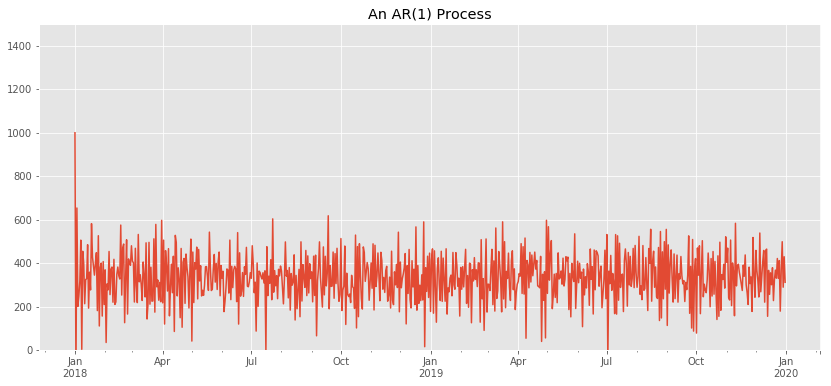

In [9]:
np.random.seed(123)
ts_values = [1000]
theta = -0.5
m = 500
for t in range(num_time_periods-1):
    next_value = m + theta*ts_values[t]+np.asscalar(np.random.normal(0, 100, 1))
    ts_values.append(next_value)
ts = pd.Series(ts_values, index=date_index)
fig, ax = plt.subplots(figsize=(14,6))
ax = ts.plot(title="An AR(1) Process")
_ = ax.set_ylim(0, 1500)

### How would you identify an AR(1) process?

We use the acf and pacf to identify an AR(1) process. If it is AR(1) we should see 

1. The correlations in the acf exponentially decaying or sinusoidal
2. In the pacf we should see a significant correlation at lag=1 and nowhere else.

This is indeed what we see.

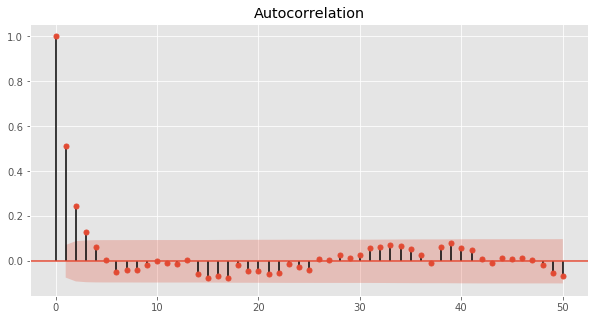

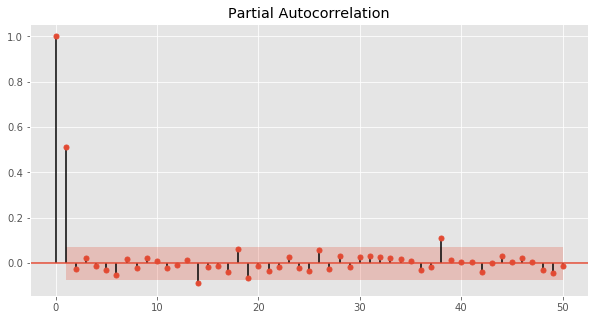

In [70]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(10,5))
    plot_acf(ts_values, lags = 50)
    plot_pacf(ts_values, lags = 50)

#### How do you fit an AR(1) model?

Now we'll need to make use of the ARIMA function in statsmodels. Specifying `order=(1,0,0)` gives us AR(1). IN the output we get AIC and BIC statistics to compare competing models, estimates of the coefficients $\mu$ and $\theta$ and p-values for tests against the null hypothesis that they equal zero. You'll see its a good model

In [71]:
model = ARIMA(ts, order=(1,0,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                     ARMA(1, 0)   Log Likelihood               -4390.709
Method:                       css-mle   S.D. of innovations             99.040
Date:                Mon, 04 Feb 2019   AIC                           8787.419
Time:                        17:24:14   BIC                           8801.198
Sample:                    01-01-2018   HQIC                          8792.735
                         - 12-31-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1000.2250      7.479    133.731      0.000     985.566    1014.884
ar.L1.y        0.5106      0.032     16.061      0.000       0.448       0.573
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9585           +0.0000j            1.9585            0.0000
-----------------------------------------------------------------------------
"""

#### How do you check that the model fits the data?

We should now check the residuals to see if they look like they come from a white noise process.

[ 0.73681002  0.71780187  0.85687968  0.92535076  0.9704384   0.6977279
  0.79689627  0.81254137  0.87760282  0.90617568]


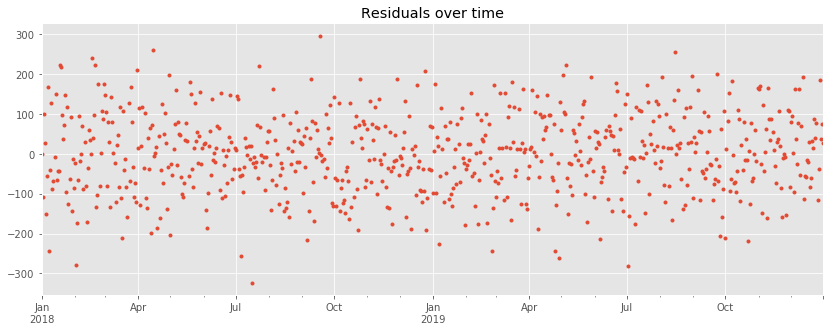

In [73]:
ts_res = pd.Series(model_fit.resid)
fig, ax = plt.subplots(figsize=(14,5))
ax = ts_res.plot(title="Residuals over time", style='.')

p_values = acorr_ljungbox(ts_res, 10)[1]
print(p_values)

Looks good!

#### How do we forecast an AR(1) process?

In python the ARIMAResults object has both a predict and a plot predict method. Notice how the prediction returns to the average after a while.

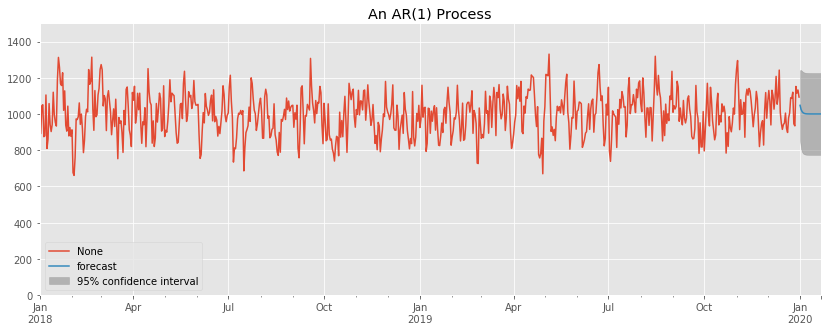

In [74]:
fig, ax = plt.subplots(figsize=(14,5))
ax = ts.plot(title="An AR(1) Process")
_ = ax.set_ylim(0, 1500)
_ = model_fit.plot_predict(num_time_periods, num_time_periods+20, dynamic=True, ax=ax,plot_insample=False)

### Scenario 3: MA(1)

The MA(1) (moving average) model is similar to the AR(1) process only this time the carryover comes not from the previous value of $Y_t$ but from the previous error term ($\epsilon_{t-1}$)

#### Where you might see this process?

A good example of this process is the sale of newspapers. The effect of the different headlines is rightly modelled as noise but a strong headline might bring in readers who stick around for the next few editions.

#### The generative model

The model for this process is

$Y_t = \mu + \phi \epsilon_{t-1} + \epsilon_t$

Where

$\epsilon_t \sim N(0, \sigma^2)$ 

and $-1 < \phi < -1 $ (A necessary condition if the process is to be stationary).


### An example

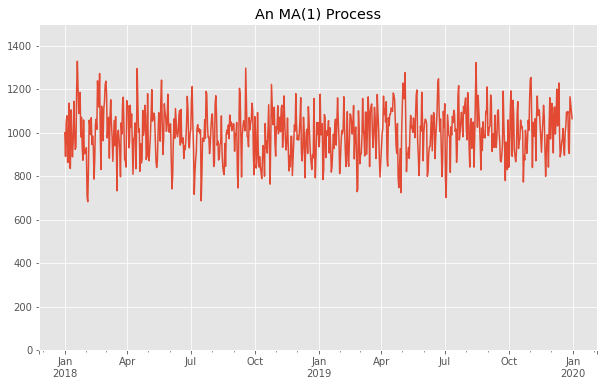

In [10]:
np.random.seed(123)
ts_values = [1000]
phi = 0.5
m = 1000
error_tm1 = 0

for t in range(num_time_periods-1):
    error_t = np.asscalar(np.random.normal(0, 100, 1))
    next_value = m + phi*error_tm1 + error_t
    ts_values.append(next_value)
    error_tm1 = error_t
    
ts = pd.Series(ts_values, index=date_index)
fig, ax = plt.subplots(figsize=(10,6))
ax = ts.plot(title="An MA(1) Process")
_ = ax.set_ylim(0, 1500)

Notice it is not easily visually to differentiate an MA(1) process from an AR(1) process. We need to use the acf and pacf plots.

### How would you identify an MA(1) process?

If it is MA(1) we should things the other way around compared to the 

1. The correlations in the **pacf** exponentially decaying or sinusoidal
2. In the *acf* we should see a significant correlation at lag=1 and nowhere else.

This is indeed what we see.

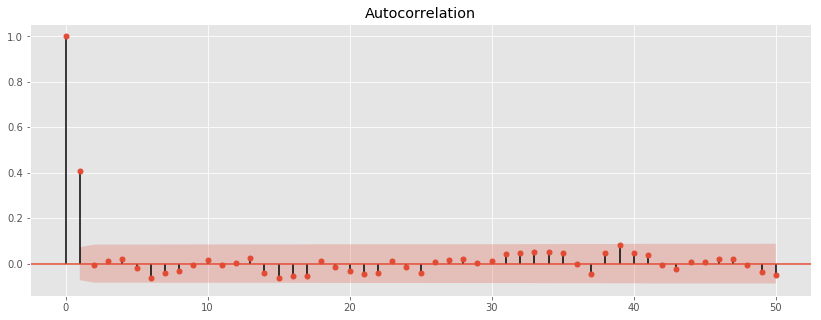

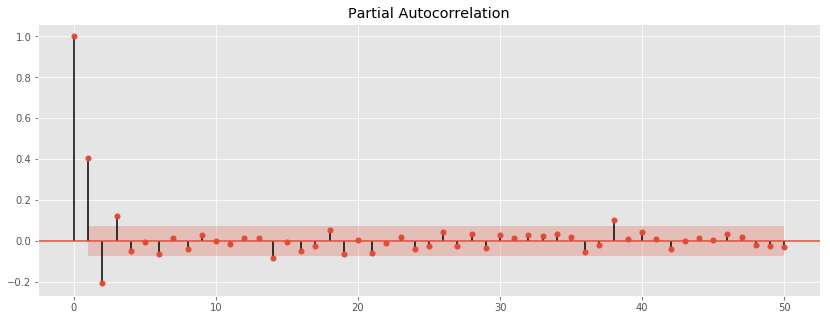

In [11]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,5))
    plot_acf(ts, lags = 50)
    plot_pacf(ts, lags = 50)

#### How do you fit an MA(1) model?

We go through the same process as for an AR(1) model only we use `order=(0,0,1)`

In [12]:
model = ARIMA(ts, order=(0,0,1))
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                     ARMA(0, 1)   Log Likelihood               -4390.297
Method:                       css-mle   S.D. of innovations             98.982
Date:                Thu, 07 Feb 2019   AIC                           8786.595
Time:                        16:08:45   BIC                           8800.374
Sample:                    01-01-2018   HQIC                          8791.911
                         - 12-31-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1000.2028      5.602    178.533      0.000     989.222    1011.183
ma.L1.y        0.5300      0.032     16.491      0.000       0.467       0.593
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.8870           +0.0000j            1.8870            0.5000
-----------------------------------------------------------------------------
"""

#### How do you check that the model fits the data?

Again we plot the residuals and carry out the Ljung-Box test.

**Task:** Carry out this analysis for yourself. Try fitting an AR(1) process to this data. What happens?


In [13]:
model = ARIMA(ts, order=(1,0,0))
model_fit = model.fit(disp=0)
model_fit.summary()

C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                     ARMA(1, 0)   Log Likelihood               -4412.754
Method:                       css-mle   S.D. of innovations            102.085
Date:                Thu, 07 Feb 2019   AIC                           8831.508
Time:                        16:08:49   BIC                           8845.287
Sample:                    01-01-2018   HQIC                          8836.824
                         - 12-31-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1000.2015      6.358    157.318      0.000     987.740    1012.663
ar.L1.y        0.4063      0.034     12.024      0.000       0.340       0.472
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4614           +0.0000j            2.4614            0.0000
-----------------------------------------------------------------------------
"""

#### How do we forecast an MA(1) process?

We can just use the same code as we used for AR(1).

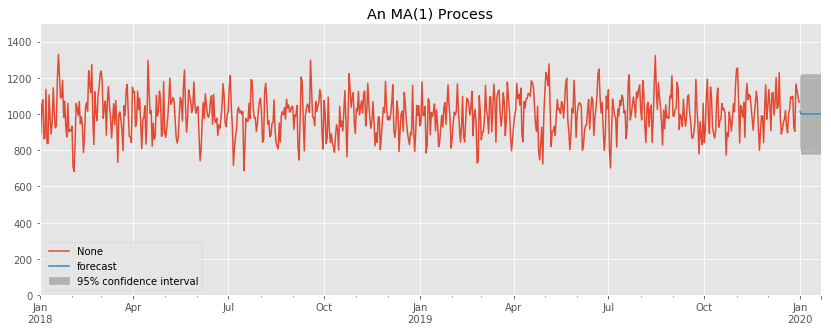

In [78]:
fig, ax = plt.subplots(figsize=(14,5))
ax = ts.plot(title="An MA(1) Process")
_ = ax.set_ylim(0, 1500)
_ = model_fit.plot_predict(num_time_periods, num_time_periods+20, dynamic=True, ax=ax,plot_insample=False)

### Scenario 4: AR(p)

This is just a generalisation of the AR(1) process. Instead of just being related to the previous term in the series $Y_t$ is now formed using a linear combination of the previous p terms.

#### Where you might see this process?

Here again we might think of the the number of active users on a platform. This time the current number of active users is made up of a certain proportion ($\theta_1$) of the number of the previous week (a carry over/retention), plus a winback ($\theta_2$) from the week before plus some additional noise caused by the net effect of acquisitions (or better than average retention) and worse than average retention.

#### The generative model

The model for this process is

$Y_t = \mu + \theta_1 Y_{t-1} + \theta_2 Y_{t-2} +... \theta_p Y_{t-p} + \epsilon_t$

Where

$\epsilon_t \sim N(0, \sigma^2)$ 

and $-1 < \theta_i < -1 $ (A necessary condition if the process is to be stationary).


### An example


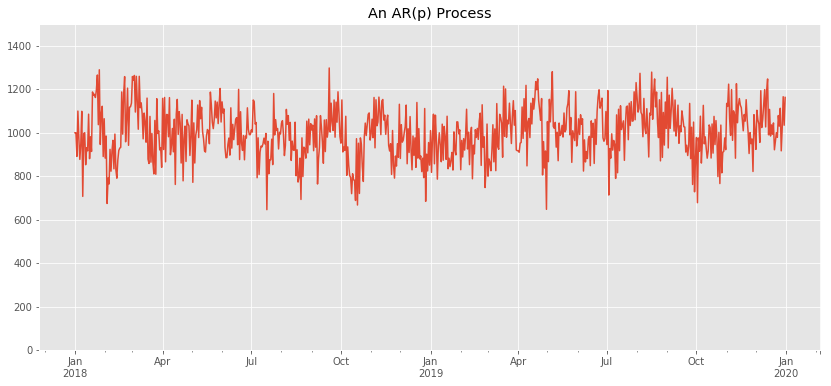

In [14]:
np.random.seed(123)
ts_values = [1000, 1000]
theta_1 = 0.5
theta_2 = 0.2
m = 300
for t in range(num_time_periods-2):
    next_value = m + theta_1*ts_values[t]+ theta_2*ts_values[t-1] + np.asscalar(np.random.normal(0, 100, 1))
    ts_values.append(next_value)
    
ts = pd.Series(ts_values, index=date_index)
fig, ax = plt.subplots(figsize=(14,6))
ax = ts.plot(title="An AR(p) Process")
_ = ax.set_ylim(0, 1500)

The runs of above and below average are now even more noticeable.

**Task:** Experiment with the values of $\theta_1$ and $\theta_2$


### How would you identify an AR(p) process?

1. As with the AR(1) process the acf should tail off (or follow a sinusidal pattern)
2. The pacf on the other hand should cut off after p (doesn't quite get it right below since it cut off after p=3 - however the diagnostic statistics are subject to variance too and so we might not get exactly the right answer.)


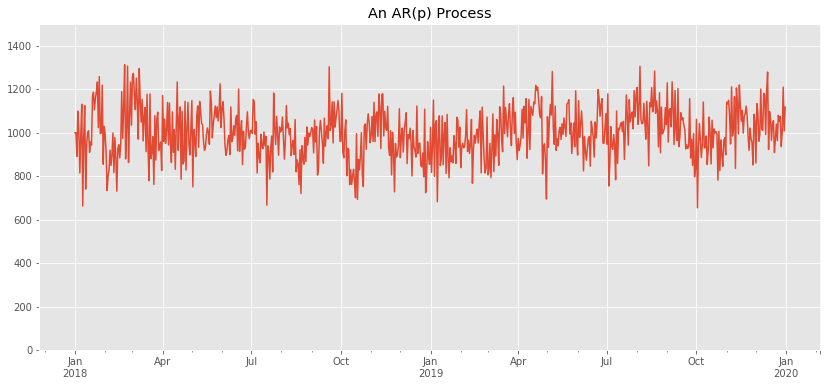

In [15]:
np.random.seed(123)
ts_values = [1000, 1000]
theta_1 = 0.2
theta_2 = 0.5
m = 300
for t in range(num_time_periods-2):
    next_value = m + theta_1*ts_values[t]+ theta_2*ts_values[t-1] + np.asscalar(np.random.normal(0, 100, 1))
    ts_values.append(next_value)
    
ts = pd.Series(ts_values, index=date_index)
fig, ax = plt.subplots(figsize=(14,6))
ax = ts.plot(title="An AR(p) Process")
_ = ax.set_ylim(0, 1500)

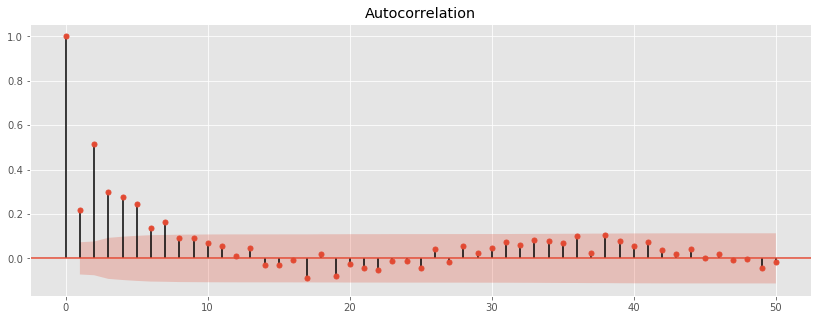

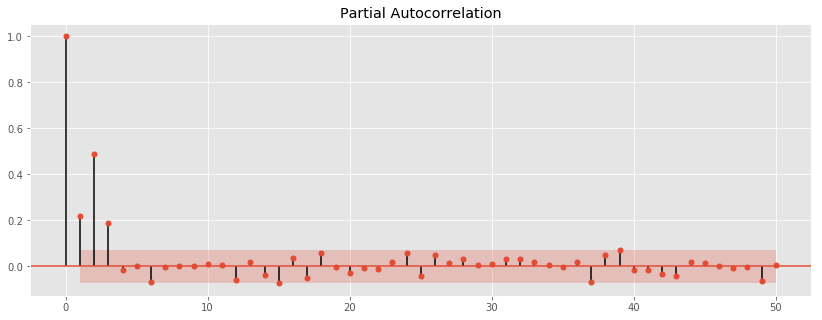

In [84]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,5))
    plot_acf(ts, lags = 50)
    plot_pacf(ts, lags = 50)

#### How do you fit an AR(p) model?

As before only now we use `order=(2,0,0)`.

In [85]:
model = ARIMA(ts, order=(2,0,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                     ARMA(2, 0)   Log Likelihood               -4403.558
Method:                       css-mle   S.D. of innovations            100.778
Date:                Mon, 04 Feb 2019   AIC                           8815.116
Time:                        17:31:31   BIC                           8833.488
Sample:                    01-01-2018   HQIC                          8822.204
                         - 12-31-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        999.8486      9.316    107.325      0.000     981.589    1018.108
ar.L1.y        0.1120      0.032      3.473      0.001       0.049       0.175
ar.L2.y        0.4891      0.032     15.173      0.000       0.426       0.552
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3200           +0.0000j            1.3200            0.0000
AR.2           -1.5489           +0.0000j            1.5489            0.5000
-----------------------------------------------------------------------------
"""

#### Checking the model fit and making a forecast is the same as for the previous examples

### Scenario 5: MA(p)

It shouldn't be hard now to guess what an MA(p) process looks like. We get a carry over from the previous p error terms that were used in generating the series.


#### Where you might see this process?

Think of the newspaper example from the MA(1) process an imagine the effect of a headline carrying over for more than one day.

#### The generative model

The model for this process is

$Y_t = \mu + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-3} + ... + \phi_p \epsilon_{t-p} + \epsilon_t$

Where

$\epsilon_t \sim N(0, \sigma^2)$ 

and $-1 < \phi_i < -1 $ (A necessary condition if the process is to be stationary).


### An example

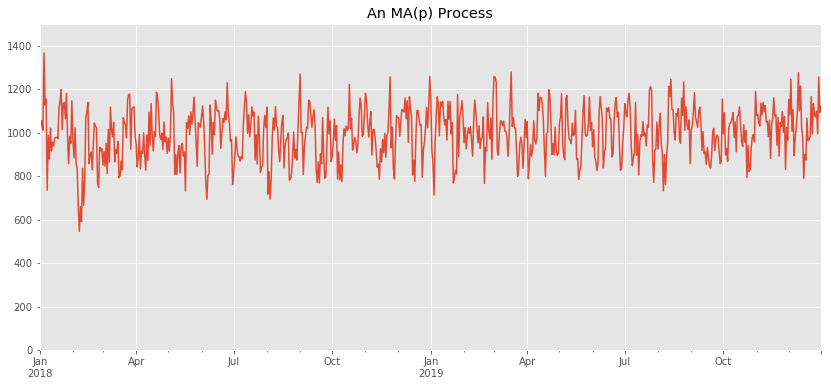

In [86]:
ts_values = [1000]
phi_1 = 0.5
phi_2 = 0.3
m = 1000
error_tm1 = 0
error_tm2 = 0

for t in range(num_time_periods-1):
    error_t = np.asscalar(np.random.normal(0, 100, 1))
    next_value = m + phi_1*error_tm1 + phi_1*error_tm2 + error_t
    ts_values.append(next_value)
    error_tm2 = error_tm1
    error_tm1 = error_t
    
ts = pd.Series(ts_values, index=date_index)
fig, ax = plt.subplots(figsize=(14,6))
ax = ts.plot(title="An MA(p) Process")
_ = ax.set_ylim(0, 1500)

Again it is difficult visually to see the difference between this process an the AR(p) process.

#### How would you identify an MA(p) process?

Fortunately we can use the pacf and acf again. As we did for the MA(1) example we just switch around the criteria for the AR(p) process. A process is MA(p) if

1. The **pacf** gradually tails off
2. The acf on the other hand should cut off after p (as we see below)


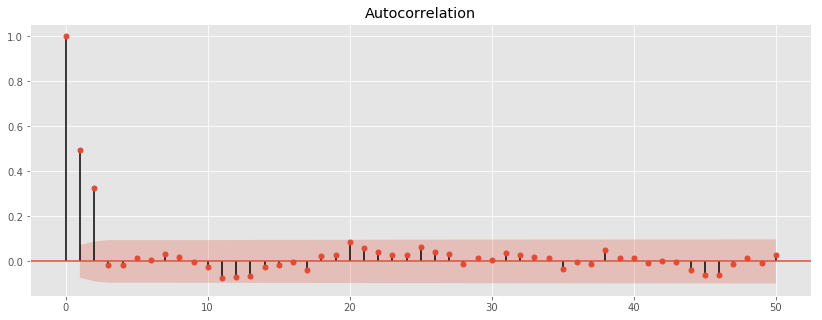

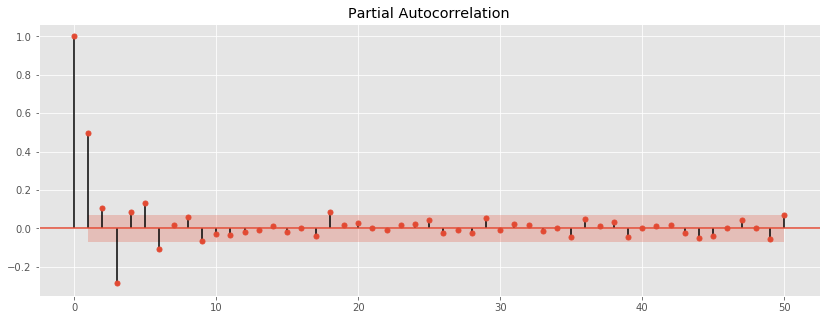

In [87]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,5))
    plot_acf(ts, lags = 50)
    plot_pacf(ts, lags = 50)

### How do you fit an MA(p) model?

To fit the MA(p) process use `order=(0,0,2)`. Forecasting and model fit proceed in the usual way

### Scenario 6: ARMA(1,1)

Next we introduce a process with both a carry over from the previous term in the series and from the previous error term.

#### Where you might see this process?

Adapting our active users on a platform example, let us suppose that the noise term captures not just natural acquistions but also things like marketing promotions. It is conceivable that these promotions have a carry over (the MA part) which can be added to the carryover of retained users.

#### The generative model

The model for this process is

$Y_t = \mu + \theta Y_{t-1} + \phi \epsilon_{t-1} + \epsilon_t$

Where

$\epsilon_t \sim N(0, \sigma^2)$ 

and $-1 < \theta < -1 $ and $-1 < \phi < -1 $


### An example


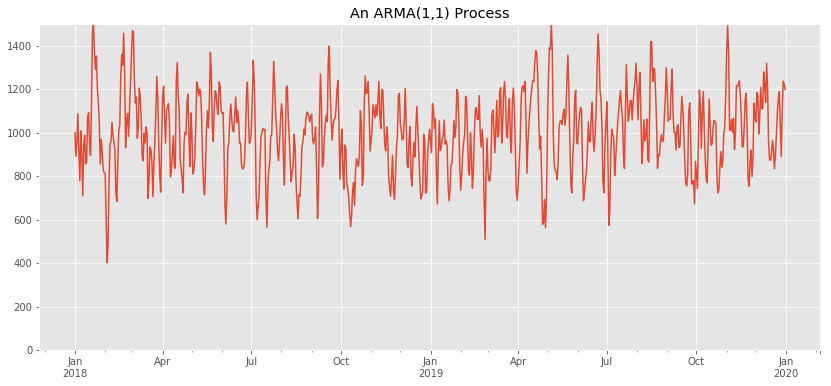

In [17]:
np.random.seed(123)
ts_values = [1000]
phi = 0.8
theta = 0.5
m = 500
error_tm1 = 0

for t in range(num_time_periods-1):
    error_t = np.asscalar(np.random.normal(0, 100, 1))
    next_value = m + theta*ts_values[t] + phi*error_tm1  + error_t
    ts_values.append(next_value)
    error_tm1 = error_t
    
ts = pd.Series(ts_values, index=date_index)
fig, ax = plt.subplots(figsize=(14,6))
ax = ts.plot(title="An ARMA(1,1) Process")
_ = ax.set_ylim(0, 1500)

### How would you identify an ARMA(1,1) process?

For ARMA(1,1) and more generally for ARMA(p,q) we should see a tail off or a sinusidal pattern in both acf and pacf.

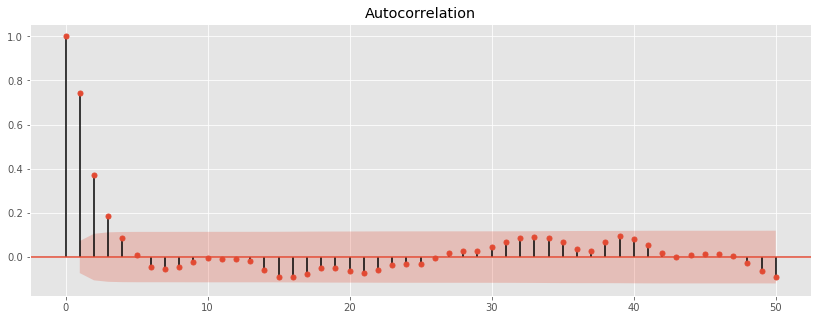

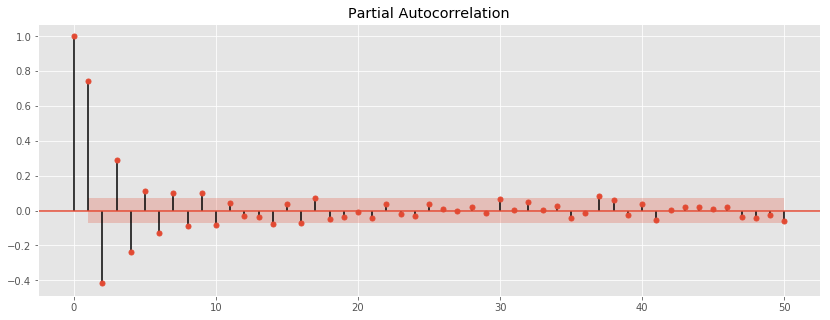

In [18]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,5))
    plot_acf(ts, lags = 50)
    plot_pacf(ts, lags = 50)

Thus if we are going to distinguish an ARMA(1,1) model from other possible values of p and q (say an ARMA(2,2 model) we will need to rely on measures of model fit. If there's any doubt then the principle of parsimony should guide us, that is we should go for lower values of p or q if they do just as well.

An ARMA(1,1) model is fit using the argument `order=(1,0,1)`. Forecasts and model fit stats are obtained in the usual way.

**Task:** Now see if you can adapt the code to produce and then analyse an ARMA(3,1) model!

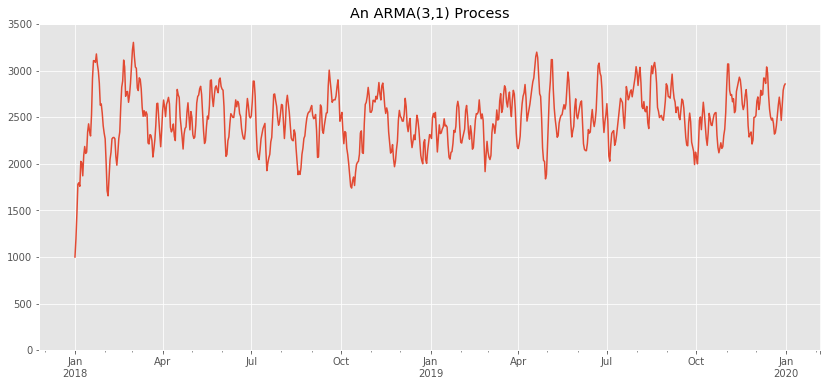

In [22]:
np.random.seed(123)
ts_values = [1000]
phi = 0.8
theta1 = 0.5
theta2 = 0.2
theta3 = 0.1
m = 500
error_tm1 = 0

for t in range(num_time_periods-1):
    error_t = np.asscalar(np.random.normal(0, 100, 1))
    next_value = m + theta1*ts_values[t] + theta2*ts_values[t] + theta3*ts_values[t] + phi*error_tm1  + error_t
    ts_values.append(next_value)
    error_tm1 = error_t
    
ts = pd.Series(ts_values, index=date_index)
fig, ax = plt.subplots(figsize=(14,6))
ax = ts.plot(title="An ARMA(3,1) Process")
_ = ax.set_ylim(0, 3500)

### Scenario 7: ARIMA(1,1, 0)

So far none of the scenarios we have looked at have been even remotely plausible for your business. None have displayed a trend or seasonality. From here on things get more realistic. First we introduce the idea that it is not that the time series itself that follows an AR(1) process but the set of differences that results from $Y_t - Y_{t-1}$ for each t.

#### Where you might see this process?

If we are modelling differences then a run of positive values among the differences is going to create a continuously climbing time series and a run of negative values among the differences is going to create a continuously descending time series. We know that high positive values for $\theta$ induce such runs so for such values we should see times series with a more wandering pattern.

#### The generative model

To describe the model for this type of process we need to introduce the idea of a differencing operator:

$(1-L)Y_t = Y_t - Y_{t-1}$

Then we have:

$(1-L)Y_t = \mu + \theta Y_{t-1} + \epsilon_t$

Where

$\epsilon_t \sim N(0, \sigma^2)$ 

and $-1 < \theta < -1 $


### An example

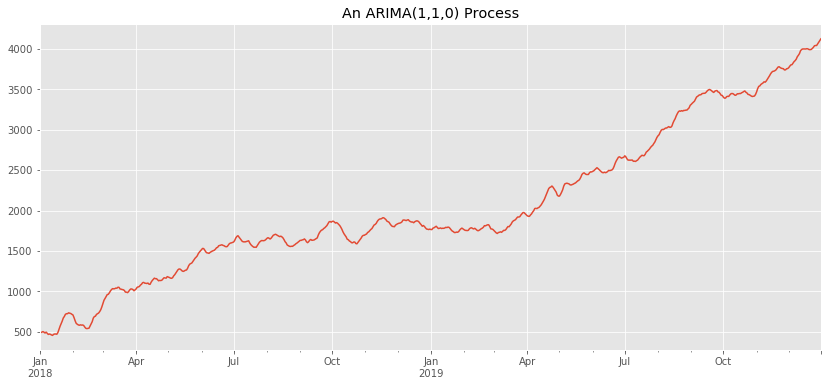

In [90]:
np.random.seed(123)
differences = [0]
theta = 0.7
mu = 1.5
for t in range(num_time_periods-1):
    next_value = mu + theta*differences[t]+np.asscalar(np.random.normal(0, 10, 1))
    differences.append(next_value)
    
    
ds = pd.Series(differences, index=date_index)
ts = ds.cumsum()+500
fig, ax = plt.subplots(figsize=(14,6))
ax = ts.plot(title="An ARIMA(1,1,0) Process")

We see that as predicted, for lower values of $\theta$ we get less wandering!

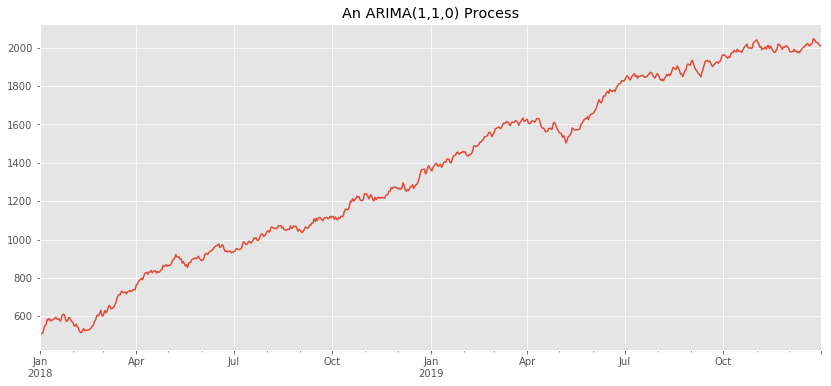

In [98]:
differences = [0]
theta = 0.05
mu = 2
for t in range(num_time_periods-1):
    next_value = mu + theta*differences[t]+np.asscalar(np.random.normal(0, 10, 1))
    differences.append(next_value)
    
    
ds = pd.Series(differences, index=date_index)
ts_lower_theta = ds.cumsum()+500
fig, ax = plt.subplots(figsize=(14,6))
ax = ts_lower_theta.plot(title="An ARIMA(1,1,0) Process")

#### How would you identify an ARIMA(1,1,0) process?

So imagine we didn't know that this was ARIMA(1,1,0). What steps would we need to go through to make the identification? 

The first thing we would note is that the series clearly isn't stationary. For example the location of the process mean seems to be increasing over time. 

We want to make it stationary so we try differencing the data.

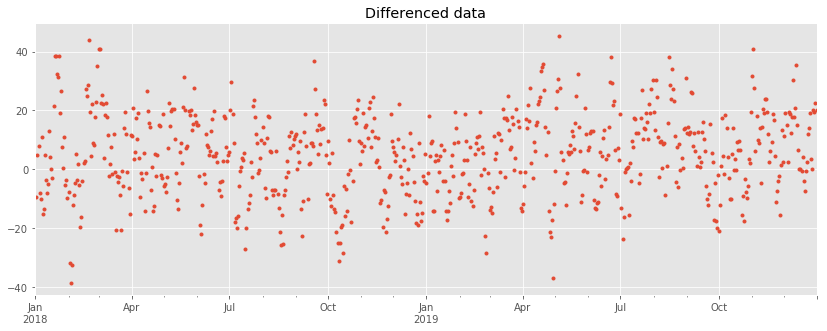

In [99]:
ts_diff = ts.diff()
fig, ax = plt.subplots(figsize=(14,5))
ax = ts_diff.plot(title="Differenced data", style='.')

This appears to have worked. The series looks stationary. Next we use the acf and pacf to work out p and q **for the differences**.

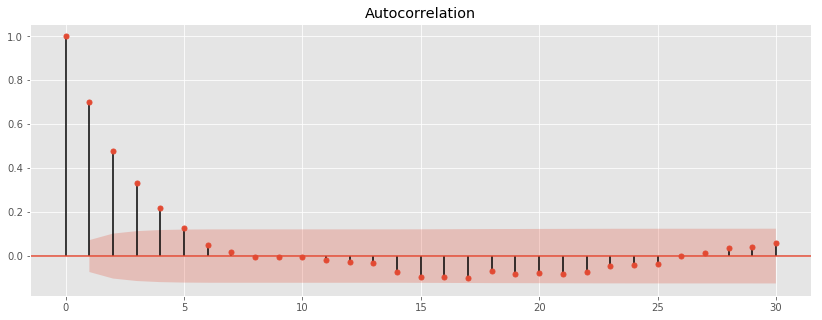

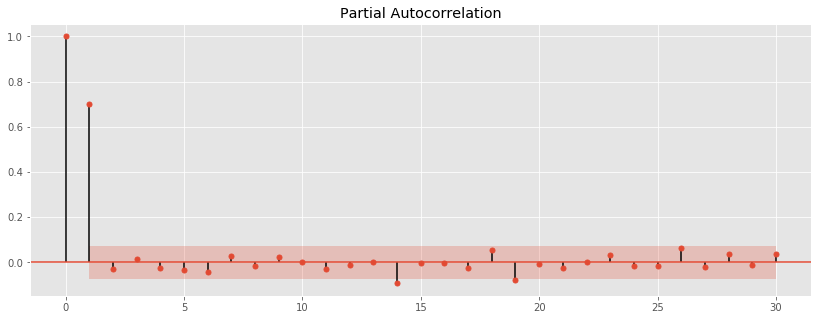

In [100]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,5))
    plot_acf(ts_diff[1:], lags = 30)
    plot_pacf(ts_diff[1:], lags = 30)

This reveals that the process for the differences is AR(1). I conclude that my model is ARIMA(1,1,0), where the first 1 gives me the autogressive order, the second 1 tells me that series was differenced once before it was stationary and the 0 tells me that there was no moving average term.

### How do you fit an ARIMA(1,1,0)  model?

In [94]:
model = ARIMA(ts, order=(1,1,0))
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  729
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2706.786
Method:                       css-mle   S.D. of innovations              9.911
Date:                Mon, 04 Feb 2019   AIC                           5419.572
Time:                        17:34:09   BIC                           5433.347
Sample:                    01-02-2018   HQIC                          5424.887
                         - 12-31-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9743      1.233      4.034      0.000       2.557       7.391
ar.L1.D.y      0.7033      0.026     26.721      0.000       0.652       0.755
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4219           +0.0000j            1.4219            0.0000
-----------------------------------------------------------------------------
"""

I should of course now check the residuals. At last though the forecast is starting to look interesting!

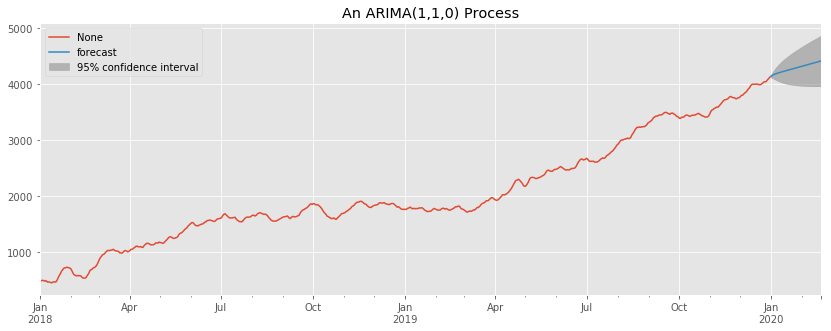

In [96]:
fig, ax = plt.subplots(figsize=(14,5))
ax = ts.plot(title="An ARIMA(1,1,0) Process")
_ = model_fit.plot_predict(num_time_periods,num_time_periods+50, dynamic=True, ax=ax,plot_insample=False)

**Task:** Adapt the code to investigate an ARIMA(0,1,1) model